In [3]:
import sympy as sym 
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, ListedColormap, BoundaryNorm

In [4]:

class Swizzle:
    
  BitAnd = sym.Function('BitAnd')
  BitOr  = sym.Function('BitOr')
  BitXor = sym.Function('BitXor')
  RShift = sym.Function('RShift')
  LShift = sym.Function('LShift')
  BitNot = sym.Function('BitNot')
  Max = sym.Max
  Min = sym.Min

  def __init__(self, m_base: int, b_bits: int, s_shift: int, N_elems: int):
      
    assert m_base >= 0 
    assert b_bits >= 0 
    assert abs(s_shift) >= b_bits 
    self.N_elems = N_elems
    
    self.m_base = sym.Integer(m_base)
    self.b_bits = sym.Integer(b_bits)
    self.s_shift = sym.Integer(s_shift)
    
    self.b = sym.Symbol('b', integer=True) 
    self.m = sym.Symbol('m', integer=True)
    self.s = sym.Symbol('s', integer=True)
    self.x = sym.Symbol('x', integer=True)

    LShift, BitAnd, BitOr = Swizzle.LShift, Swizzle.BitAnd, Swizzle.BitOr
    BitXor, RShift = Swizzle.BitXor, Swizzle.RShift
    Max, Min = Swizzle.Max, Swizzle.Min

    one = sym.Integer(1) 
    zero = sym.Integer(0)

    base_mask = (LShift(one, self.b)) - 1
    src_shift = self.m + Max(zero, self.s)
    dst_shift = self.m - Min(zero, self.s)
    
    src_mask = LShift(base_mask, src_shift) 
    dst_mask = LShift(base_mask, dst_shift)
    
    bits_to_move = BitAnd(self.x, src_mask)
    
    self.swizzle_mask = BitOr(src_mask, dst_mask)
    
    expr_pos_s = BitXor(self.x, RShift(bits_to_move, self.s))
    expr_neg_s = BitXor(self.x, LShift(bits_to_move, -self.s))

    self.swizzle_map_sym = sym.Piecewise(
        (expr_pos_s, self.s >= 0),
        (expr_neg_s, True)
    )
    self.swizzle_map = self._substitute(self.swizzle_map_sym, (self.m_base, self.b_bits, self.s_shift), (self.m, self.b, self.s))
    self.realized_swizzle_map = "un_realized"
    

  def __repr__(self):
    return (
        f"Swizzle(\n"
        f"  symbols = ({self.b}, {self.m}, {self.s}, {self.x}),\n"
        f"  mask    = {self.swizzle_mask},\n"
        f"  map     = {self.swizzle_map_sym}\n"
        f")"
    )
      
  def _get_realization_map(self):
    import numpy as np
    return {
        'BitAnd': np.bitwise_and,
        'BitOr':  np.bitwise_or,
        'BitXor': np.bitwise_xor,
        'RShift': np.right_shift,
        'LShift': np.left_shift,
        'BitNot': np.invert,
        'Max':    np.maximum,
        'Min':    np.minimum
    }
  
  def _substitute (self, expr: sym.Expr, new_symbols: Tuple[sym.Expr,...], old_symbols: Tuple[sym.Expr,...]): 
    new_expr = expr 
    for i in range(len(new_symbols)): 
      new_expr = new_expr.subs(old_symbols[i], new_symbols[i])
      
    return new_expr
  
  def realize(self):
    ops = self._get_realization_map()
    func_lamb = sym.lambdify(
            self.x, 
            self.swizzle_map, 
            modules=['numpy', ops]
        )
    arr = np.arange(self.N_elems)
    self.realized_swizzle_map = func_lamb(arr)
  
    

In [5]:
class Layout: 
  def __init__ (self, shape: Tuple[int,...], stride: Tuple[int,...], 
                kind: str):
    
    assert len(shape) == len(stride) 
    self.m = len(shape)
    self.shape = tuple([sym.Integer(shape[i]) for i in range(self.m)])
    self.stride = tuple([sym.Integer(stride[i]) for i in range(self.m)])
    self.S = tuple([sym.Symbol(f"S_{str(i)}") for i in range(self.m)])
    self.S_S = [sym.Integer(1)]*self.m
    self.D = tuple([sym.Symbol(f"D_{str(i)}") for i in range(self.m)])
    self.I = sym.Symbol("x")
    self.N_elems = 1 
    for i in range(self.m): 
      self.N_elems *= shape[i]
      
    
    for i in range(1,self.m): 
      self.S_S[i] = self.S[i-1]*self.S_S[i-1]
      
    self.S_S = tuple(self.S_S)  
    

    self.fan_out = [0]*self.m 
    for i in range(self.m): 
      self.fan_out[i] = (self.I // self.S_S[i]) % self.S[i]
    
    self.fan_out = tuple(self.fan_out)
    
    self.fan_in = sym.Integer(0) 
    self.fan_out_sym = tuple([sym.Symbol(f"y_{str(i)}") for i in range(self.m)])
    for i in range(self.m):
      self.fan_in += self.D[i]*self.fan_out_sym[i]
      
    self.layout_sym = self._substitute(self.fan_in, self.fan_out, self.fan_out_sym)
    self.layout = self._substitute(self.layout_sym, self.shape, self.S)
    self.layout = self._substitute(self.layout, self.stride, self.D)
    self.realized_layout = "un_realized"
    
    
  
  def _substitute (self, expr: sym.Expr, new_symbols: Tuple[sym.Expr,...], old_symbols: Tuple[sym.Expr,...]): 
    new_expr = expr 
    for i in range(len(new_symbols)): 
      new_expr = new_expr.subs(old_symbols[i], new_symbols[i])
      
    return new_expr
  
  def realize(self): 
    one_d_domain = np.arange(self.N_elems) 
    layout_lambda = sym.lambdify([self.I], self.layout, "numpy")
    self.realized_layout = layout_lambda(one_d_domain).astype(int)
    
   



In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm, Normalize

class Draw:
    """
    Visualizes a 1D realized layout array as a 2D tile,
    with a specified fill order (row-major or column-major).
    Supports Address gradient coloring and Bank grouping.
    """
    
    # A default palette of 32 distinct colors for the banks
    DEFAULT_BANK_COLORS = [
        "#1F77B4", "#AEC7E8", "#FF7F0E", "#FFBB78", "#2CA02C", "#98DF8A", "#D62728", "#FF9896",
        "#9467BD", "#C5B0D5", "#8C564B", "#C49C94", "#E377C2", "#F7B6D2", "#7F7F7F", "#C7C7C7",
        "#BCBD22", "#DBDB8D", "#17BECF", "#9EDAE5", "#393B79", "#637939", "#8C6D31", "#843C39",
        "#7B4173", "#5254A3", "#8CA252", "#BD9E39", "#AD494A", "#A55194", "#6B6ECF", "#B5CF6B"
    ]

    def __init__(self, layout_data: np.ndarray, display_dim: int, order: str = 'row'):
        """
        Initializes the drawer with layout data and display shape.
        """
        if not isinstance(layout_data, np.ndarray) or layout_data.ndim != 1:
            raise ValueError("layout_data must be a 1D numpy array.")
        if not isinstance(display_dim, int) or display_dim <= 0:
            raise ValueError("display_dim must be a positive integer.")
        if order not in ['row', 'col']:
            raise ValueError("order must be 'row' or 'col'.")
            
        self.data = layout_data
        self.N = self.data.shape[0]
        self.order = order
        
        # 1. Determine grid shape
        if self.order == 'row':
            self.cols = display_dim
            self.rows = int(np.ceil(self.N / self.cols))
            self.reshape_order = 'C'
        else:
            self.rows = display_dim
            self.cols = int(np.ceil(self.N / self.rows))
            self.reshape_order = 'F'
            
        # 2. Pad data with NaN
        padded_size = self.rows * self.cols
        self.padded_data = np.full(padded_size, np.nan)
        self.padded_data[:self.N] = self.data
        
        # 3. Reshape to grid
        self.grid_data = self.padded_data.reshape(self.rows, self.cols, 
                                                  order=self.reshape_order)

    def show(self, title: str = None, mode: str = 'address', bank_colors: list = None, group_banks: int = 1):
        """
        Displays the 2D plot of the memory layout.
        
        :param title: The title for the plot.
        :param mode: 'address' (gradient based on value) or 'bank' (discrete based on % 32).
        :param bank_colors: List of hex strings. Used only if mode='bank'.
        :param group_banks: Integer (default 1). Groups contiguous banks into a single color.
                            E.g., if 4: Banks 0-3 = Color 0, Banks 4-7 = Color 1.
        """
        fig, ax = plt.subplots(figsize=(max(8, self.cols * 0.6), max(6, self.rows * 0.6)))
        
        # --- Determine Coloring Strategy ---
        if mode == 'bank':
            # Calculate how many distinct groups (colors) we need
            num_groups = 32 // group_banks
            
            # 1. Prepare Colors
            colors = bank_colors if bank_colors else self.DEFAULT_BANK_COLORS
            # Slice colors so we only use as many as we have groups
            # We cycle them if we somehow have weird group sizes, but standard is fine
            active_colors = colors[:num_groups]
            
            if len(active_colors) < num_groups:
                 # Fallback if user provided custom list that was too short
                 raise ValueError(f"Need at least {num_groups} colors for group_banks={group_banks}")

            # Create a discrete colormap
            cmap = ListedColormap(active_colors)
            norm = BoundaryNorm(np.arange(num_groups + 1), cmap.N) 
            
            # 2. Prepare Data (Bank Group ID)
            plot_data = self.grid_data.copy()
            nan_mask = np.isnan(plot_data)
            temp_filled = np.nan_to_num(plot_data, nan=0)
            
            # LOGIC:
            # 1. Get raw bank (0-31)
            # 2. Integer divide by group_banks to get Group ID
            raw_bank = temp_filled.astype(int) % 32
            plot_data = raw_bank // group_banks
            
            # Restore NaNs
            plot_data = plot_data.astype(float)
            plot_data[nan_mask] = np.nan
            
            if title is None:
                title = f"Memory Layout (Bank Groups of {group_banks})"
            
        else: # mode == 'address'
            plot_data = self.grid_data
            min_val = np.nanmin(self.data)
            max_val = np.nanmax(self.data)
            cmap = plt.get_cmap('jet')
            norm = Normalize(vmin=min_val, vmax=max_val)
            
            if title is None:
                title = "Memory Layout (Address Gradient)"

        # --- Plotting ---
        im = ax.imshow(plot_data, cmap=cmap, norm=norm, interpolation='nearest')
        
        # Colorbar setup
        cbar = fig.colorbar(im, ax=ax, extend='neither')
        if mode == 'bank':
            cbar.set_label(f'Bank Group ID (0-{num_groups-1})')
            cbar.set_ticks(np.arange(0.5, num_groups, 1))
            cbar.set_ticklabels(range(num_groups))
        else:
            cbar.set_label('Physical Address')
        
        # --- Annotation ---
        for r in range(self.rows):
            for c in range(self.cols):
                physical_address = self.grid_data[r, c] 
                
                if not np.isnan(physical_address):
                    if mode == 'bank':
                        # To pick text color, we need the Group ID that determined the background color
                        raw_val = int(physical_address) % 32
                        val_for_color = raw_val // group_banks
                    else:
                        val_for_color = physical_address
                        
                    rgba = cmap(norm(val_for_color))
                    
                    # Calculate luminance for text contrast
                    luminance = 0.299*rgba[0] + 0.587*rgba[1] + 0.114*rgba[2]
                    text_color = 'w' if luminance < 0.5 else 'k'
                    
                    text = f"{int(physical_address)}"
                    ax.text(c, r, text, ha='center', va='center', color=text_color, fontsize=9)

        # --- Formatting ---
        ax.set_title(title, fontsize=16, fontweight='bold')
        ax.set_xlabel("Display Column")
        ax.set_ylabel("Display Row")
        
        ax.set_xticks(np.arange(self.cols))
        ax.set_yticks(np.arange(self.rows))
        ax.set_xticklabels(np.arange(self.cols))
        ax.set_yticklabels(np.arange(self.rows))
        
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

        # Minor grid lines
        ax.set_xticks(np.arange(self.cols+1)-.5, minor=True)
        ax.set_yticks(np.arange(self.rows+1)-.5, minor=True)
        ax.grid(which="minor", color="w", linestyle='-', linewidth=1)
        ax.tick_params(which="minor", bottom=False, left=False)
        
        fig.tight_layout()
        plt.show()

# OMG I JUST FUCKING REALIZED THAT int4 is not a 4 bit int its a 4 vector of 32 bit ints MFS MAKING ME TRIP

In [7]:
def expand(layout, n_elems_per_vector, n_bytes_per_elem): 
  g = n_elems_per_vector * n_bytes_per_elem
  layout_to_bytes = np.zeros((np.size(layout),g)).astype(int)
  for i in range(g):
    layout_to_bytes[:,i] = g*layout + i 
    
  return layout_to_bytes.flatten()
    

In [8]:
L = Layout((8,8), (8,1), "na")
L.realize()
X = L.realized_layout

In [9]:
X


array([ 0,  8, 16, 24, 32, 40, 48, 56,  1,  9, 17, 25, 33, 41, 49, 57,  2,
       10, 18, 26, 34, 42, 50, 58,  3, 11, 19, 27, 35, 43, 51, 59,  4, 12,
       20, 28, 36, 44, 52, 60,  5, 13, 21, 29, 37, 45, 53, 61,  6, 14, 22,
       30, 38, 46, 54, 62,  7, 15, 23, 31, 39, 47, 55, 63])

In [10]:
Y = expand(X, 4, 4)

In [11]:
S = Swizzle( 4,3,3, 1024)
S.realize()
s_map = S.realized_swizzle_map
Y_swiz = s_map[Y]

In [12]:
Y_swiz

array([  0,   1,   2, ..., 909, 910, 911], shape=(1024,))

In [13]:
D = Draw(8*np.unique((Y_swiz//8)), 8, order = 'row')

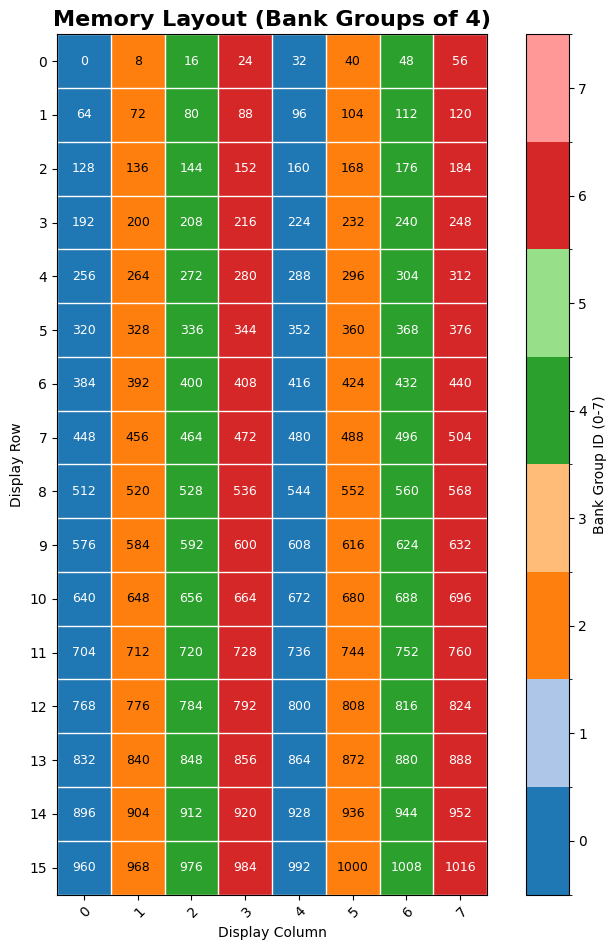

In [14]:
D.show(mode = 'bank',group_banks=4)

In [15]:
print(4096/64)

64.0


In [16]:
L = Layout((8,32),(1,8), "na")

In [17]:
L.realize()

In [22]:
D = Draw(L.realized_layout, 32, 'col')

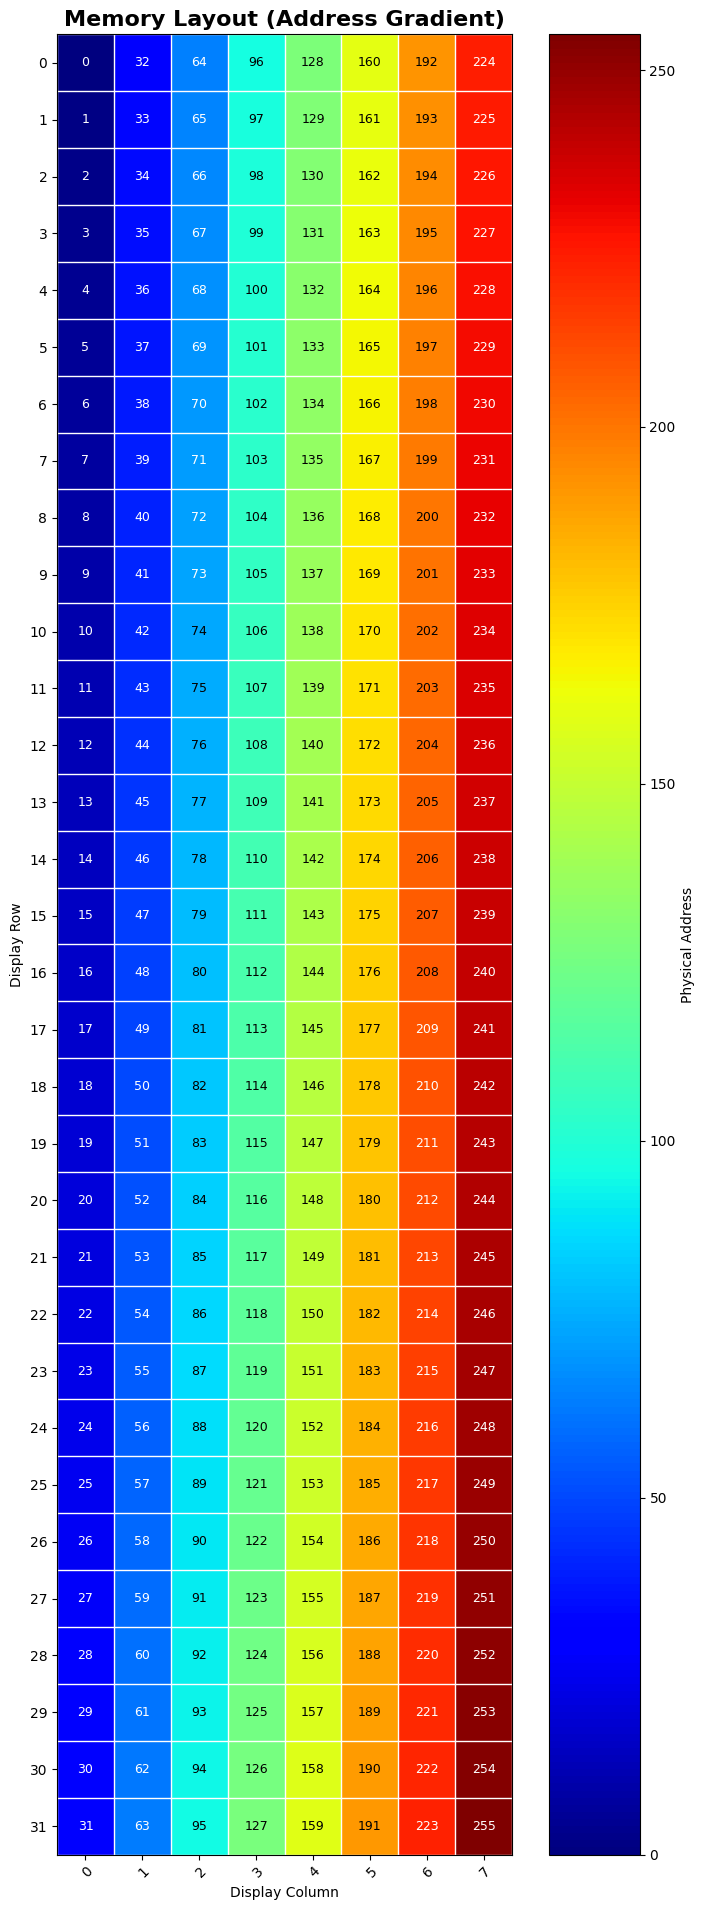

In [23]:
D.show()